In [1]:
import pandas as pd

# load the data
user_engage = pd.read_csv("../data/takehome_user_engagement.csv")
# to avoid UnicodeDecodeError: 'utf-8' code, define encoding
users = pd.read_csv("../data/takehome_users.csv",
                    encoding='latin-1')

In [2]:
user_engage['time_stamp'] = pd.to_datetime(user_engage['time_stamp'])
print(type(user_engage['time_stamp'][0]))

user_engage['date'] = user_engage['time_stamp'].map(lambda x: x.date())

user_engage = user_engage.drop_duplicates(subset=['user_id', 'date'], keep='last')

user_engage = user_engage.pivot_table(index='date', columns='user_id', 
                                      values='visited', aggfunc='sum').fillna(0)

user_engage = user_engage.rolling(7).sum()

user_engage = user_engage >= 3

user_engage = user_engage.replace(False, pd.np.nan).dropna(axis=1, how='all')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [3]:
adopted_users = pd.DataFrame({"user_id":user_engage.columns.values})


adopted_users_details = pd.merge(adopted_users, 
                                 users, 
                                 how = "left", 
                                 left_on= "user_id", 
                                 right_on = "object_id")

## visualizations

In [4]:
# functions for visualizations
%matplotlib inline

def plt_donutpie(legends,data,title):
    
    """
    plot a donut pie chart
    
    arg:
        legends: list; a list of legends
        data: list; a list of data
        title: str; plot title
        
    return:
        donut pie chart
    
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(legends[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    if title != None:
        ax.set_title(title)
          
    plt.show()
    
    return "Done"

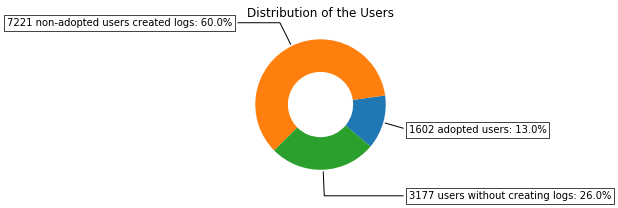

'Done'

In [5]:
data = [1602,7221,3177]
legends = ["{} adopted users: {}%".format(data[0],round(data[0]/sum(data),2) *100),
           "{} non-adopted users created logs: {}%".format(data[1],round(data[1]/sum(data),2) *100),
           "{} users without creating logs: {}%".format(data[2],round(data[2]/sum(data),2) *100),
          ]
title = "Distribution of the Users"

# plt pie chart
plt_donutpie(legends,data,title)


In [6]:
creation_source_adopted = adopted_users_details.groupby("creation_source").count().reset_index()[["creation_source", "user_id"]]

creation_source_adopted.columns = ["creation_source", "adopted_user_count"]

creation_source_adopted

,creation_source,adopted_user_count
0,GUEST_INVITE,360
1,ORG_INVITE,553
2,PERSONAL_PROJECTS,164
3,SIGNUP,293
4,SIGNUP_GOOGLE_AUTH,232


In [7]:
creation_source_users = users.groupby("creation_source").count().reset_index()[["creation_source", "object_id"]]
creation_source_users.columns = ["creation_source", "total_user_count"]
creation_source_users


,creation_source,total_user_count
0,GUEST_INVITE,2163
1,ORG_INVITE,4254
2,PERSONAL_PROJECTS,2111
3,SIGNUP,2087
4,SIGNUP_GOOGLE_AUTH,1385


In [8]:
user_engage_log_atleast1 = pd.read_csv("../data/takehome_user_engagement.csv")
user_engage_log_atleast1 = user_engage_log_atleast1[['user_id']]
user_engage_log_atleast1 = user_engage_log_atleast1.drop_duplicates()

user_engage_log_atleast1_details = pd.merge(user_engage_log_atleast1, 
                                            users, 
                                            how = "left", 
                                            left_on= "user_id", 
                                            right_on = "object_id")

creation_source_user_engage_log_atleast1 = user_engage_log_atleast1_details.groupby("creation_source").count().reset_index()[["creation_source", "object_id"]]
creation_source_user_engage_log_atleast1.columns = ["creation_source", "logged_user_count"]
creation_source_user_engage_log_atleast1


,creation_source,logged_user_count
0,GUEST_INVITE,1588
1,ORG_INVITE,3188
2,PERSONAL_PROJECTS,764
3,SIGNUP,1898
4,SIGNUP_GOOGLE_AUTH,1385


In [9]:
creation_source_summary = pd.concat([creation_source_users,
                                     creation_source_user_engage_log_atleast1['logged_user_count'],
                                     creation_source_adopted['adopted_user_count']], 
                                     axis=1, 
                                     join_axes=[creation_source_users.index])

creation_source_summary['conversion_total_to_logged'] = round(creation_source_summary['logged_user_count']/creation_source_summary['total_user_count'],2)
creation_source_summary['conversion_logged_to_adopted'] = round(creation_source_summary['adopted_user_count']/creation_source_summary['logged_user_count'],2)
creation_source_summary['conversion_total_to_adopted'] = round(creation_source_summary['adopted_user_count']/creation_source_summary['total_user_count'],2)
creation_source_summary


,creation_source,total_user_count,logged_user_count,adopted_user_count,conversion_total_to_logged,conversion_logged_to_adopted,conversion_total_to_adopted
0,GUEST_INVITE,2163,1588,360,0.73,0.23,0.17
1,ORG_INVITE,4254,3188,553,0.75,0.17,0.13
2,PERSONAL_PROJECTS,2111,764,164,0.36,0.21,0.08
3,SIGNUP,2087,1898,293,0.91,0.15,0.14
4,SIGNUP_GOOGLE_AUTH,1385,1385,232,1.00,0.17,0.17


## visualizations

In [10]:
def plt_barchart(val_names, group_name, values_group1, values_group2, values_group3):
    
    # libraries
    import numpy as np
    import matplotlib.pyplot as plt

    # set width of bar
    barWidth = 0.15

    # set height of bar
    bars1 = [values_group1[0], values_group2[0], values_group3[0]]
    bars2 = [values_group1[1], values_group2[1], values_group3[1]]
    bars3 = [values_group1[2], values_group2[2], values_group3[2]]
    bars4 = [values_group1[3], values_group2[3], values_group3[3]]
    bars5 = [values_group1[4], values_group2[4], values_group3[4]]
    
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]

    # Make the plot
    plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label=val_names[0])
    plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label=val_names[1])
    plt.bar(r3, bars3, color='#bc5090', width=barWidth, edgecolor='white', label=val_names[2])
    plt.bar(r4, bars4, color='#ff6361', width=barWidth, edgecolor='white', label=val_names[3])
    plt.bar(r5, bars5, color='#ffa600', width=barWidth, edgecolor='white', label=val_names[4])

    # Add xticks on the middle of the group bars
    plt.xlabel('user group', fontweight='bold')
    plt.ylabel('count', fontweight='bold')
    
    plt.xticks([r + barWidth for r in range(len(bars1))], 
               group_name,
               rotation= 20)


    # Create legend & Show graphic
    plt.legend()
    
    return "Done"

'Done'

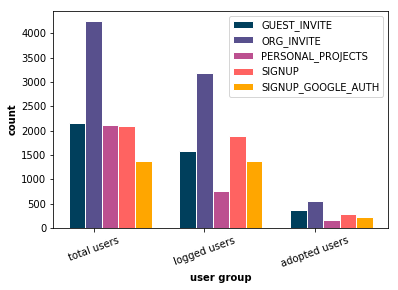

In [11]:
val_names = list(creation_source_summary['creation_source'])
values_group1 = list(creation_source_summary['total_user_count']) # for 1602 adopted users
values_group2 = list(creation_source_summary['logged_user_count']) # for 7221 logged users but not adopted users
values_group3 = list(creation_source_summary['adopted_user_count']) # for 3177 users only signed up but not logged

group_name = ['total users', 
              'logged users', 
              'adopted users']


plt_barchart(val_names, 
             group_name, 
             values_group1, 
             values_group2, 
             values_group3)

In [12]:
opted_in_to_mailing_list_totaluser = users.groupby("opted_in_to_mailing_list").count().reset_index()[["opted_in_to_mailing_list", "object_id"]]
opted_in_to_mailing_list_totaluser.columns = ["opted_in_to_mailing_list", "total_user_count"]

opted_in_to_mailing_list_logged = user_engage_log_atleast1_details.groupby("opted_in_to_mailing_list").count().reset_index()[["opted_in_to_mailing_list", "user_id"]]
opted_in_to_mailing_list_logged.columns = ["opted_in_to_mailing_list", "logged_user_count"]

opted_in_to_mailing_list_adopted = adopted_users_details.groupby("opted_in_to_mailing_list").count().reset_index()[["opted_in_to_mailing_list", "user_id"]]
opted_in_to_mailing_list_adopted.columns = ["opted_in_to_mailing_list", "adopted_user_count"]


mailing_list_summary = pd.concat([opted_in_to_mailing_list_totaluser,
                                  opted_in_to_mailing_list_logged['logged_user_count'],
                                  opted_in_to_mailing_list_adopted['adopted_user_count']], 
                                  axis=1, 
                                  join_axes=[opted_in_to_mailing_list_totaluser.index])

mailing_list_summary['conversion_total_to_logged'] = round(mailing_list_summary['logged_user_count']/mailing_list_summary['total_user_count'],2)
mailing_list_summary['conversion_logged_to_adopted'] = round(mailing_list_summary['adopted_user_count']/mailing_list_summary['logged_user_count'],2)
mailing_list_summary



,opted_in_to_mailing_list,total_user_count,logged_user_count,adopted_user_count,conversion_total_to_logged,conversion_logged_to_adopted
0,0,9006,6597,1188,0.73,0.18
1,1,2994,2226,414,0.74,0.19


In [13]:

# marketing drip
enabled_for_marketing_drip_totaluser = users.groupby("enabled_for_marketing_drip").count().reset_index()[["enabled_for_marketing_drip", "object_id"]]
enabled_for_marketing_drip_totaluser.columns = ["enabled_for_marketing_drip", "total_user_count"]

enabled_for_marketing_drip_logged = user_engage_log_atleast1_details.groupby("enabled_for_marketing_drip").count().reset_index()[["enabled_for_marketing_drip", "user_id"]]
enabled_for_marketing_drip_logged.columns = ["enabled_for_marketing_drip", "logged_user_count"]

enabled_for_marketing_drip_adopted = adopted_users_details.groupby("enabled_for_marketing_drip").count().reset_index()[["enabled_for_marketing_drip", "user_id"]]
enabled_for_marketing_drip_adopted.columns = ["enabled_for_marketing_drip", "adopted_user_count"]


marketing_drip_summary = pd.concat([enabled_for_marketing_drip_totaluser,
                                    enabled_for_marketing_drip_logged['logged_user_count'],
                                    enabled_for_marketing_drip_adopted['adopted_user_count']], 
                                    axis=1, 
                                    join_axes=[enabled_for_marketing_drip_totaluser.index])

marketing_drip_summary['conversion_total_to_logged'] = round(marketing_drip_summary['logged_user_count']/marketing_drip_summary['total_user_count'],2)
marketing_drip_summary['conversion_logged_to_adopted'] = round(marketing_drip_summary['adopted_user_count']/marketing_drip_summary['logged_user_count'],2)
marketing_drip_summary


,enabled_for_marketing_drip,total_user_count,logged_user_count,adopted_user_count,conversion_total_to_logged,conversion_logged_to_adopted
0,0,10208,7482,1356,0.73,0.18
1,1,1792,1341,246,0.75,0.18


In [14]:
# org_id
org_id_totaluser = users.groupby("org_id").count().reset_index()[["org_id", "object_id"]]
org_id_totaluser.columns = ["org_id", "total_user_count"]

org_id_totaluser

org_id_logged = user_engage_log_atleast1_details.groupby("org_id").count().reset_index()[["org_id", "user_id"]]
org_id_logged.columns = ["org_id", "logged_user_count"]

org_id_logged

org_id_adopted = adopted_users_details.groupby("org_id").count().reset_index()[["org_id", "user_id"]]
org_id_adopted.columns = ["org_id", "adopted_user_count"]

org_id_adopted


org_id_summary = pd.concat([org_id_totaluser,
                            org_id_logged['logged_user_count'],
                            org_id_adopted['adopted_user_count']], 
                            axis=1, 
                            join_axes=[org_id_totaluser.index])

# Some orgainzations do not have adopted users, so that having NaN in 'adopted_user_count'
org_id_summary = org_id_summary.fillna(0)

org_id_summary['conversion_total_to_logged'] = round(org_id_summary['logged_user_count']/org_id_summary['total_user_count'],2)
org_id_summary['conversion_logged_to_adopted'] = round(org_id_summary['adopted_user_count']/org_id_summary['logged_user_count'],2)
org_id_summary['conversion_total_to_adopted'] = round(org_id_summary['adopted_user_count']/org_id_summary['total_user_count'],2)
org_id_summary = org_id_summary.sort_values(by='conversion_total_to_adopted', ascending=False)

org_id_summary


,org_id,total_user_count,logged_user_count,adopted_user_count,conversion_total_to_logged,conversion_logged_to_adopted,conversion_total_to_adopted
183,183,11,8,6.0,0.73,0.75,0.55
374,374,14,11,7.0,0.79,0.64,0.50
353,353,10,6,5.0,0.60,0.83,0.50
399,399,13,10,6.0,0.77,0.60,0.46
386,386,7,4,3.0,0.57,0.75,0.43
379,379,14,12,6.0,0.86,0.50,0.43
151,151,17,10,7.0,0.59,0.70,0.41
180,180,17,11,7.0,0.65,0.64,0.41
310,310,15,9,6.0,0.60,0.67,0.40
300,300,15,10,6.0,0.67,0.60,0.40


Text(0, 0.5, 'Total conversion rate to adopted users')

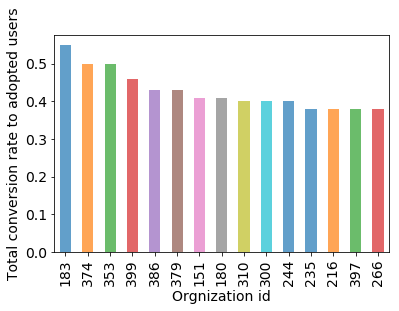

In [15]:
fontsize = 14
ax = org_id_summary.head(15).plot.bar(x='org_id', 
                                      y='conversion_total_to_adopted', 
                                      alpha = 0.7,
                                      legend= False, fontsize = fontsize)

ax.set_xlabel("Orgnization id", fontsize = fontsize)
ax.set_ylabel("Total conversion rate to adopted users", fontsize = fontsize)


In [16]:
# invited_by_user_id
invited_by_user_id_totaluser = users.groupby("invited_by_user_id").count().reset_index()[["invited_by_user_id", "object_id"]]
invited_by_user_id_totaluser.columns = ["invited_by_user_id", "total_user_count"]

# invited_by_user_id_totaluser
invited_by_user_id_logged = user_engage_log_atleast1_details.groupby("invited_by_user_id").count().reset_index()[["invited_by_user_id", "user_id"]]
invited_by_user_id_logged.columns = ["invited_by_user_id", "logged_user_count"]

invited_by_user_id_adopted = adopted_users_details.groupby("invited_by_user_id").count().reset_index()[["invited_by_user_id", "user_id"]]
invited_by_user_id_adopted.columns = ["invited_by_user_id", "adopted_user_count"]
invited_by_user_id_adopted

temp_df = pd.merge(invited_by_user_id_totaluser,invited_by_user_id_logged, how= "left", 
                   left_on='invited_by_user_id', right_on= 'invited_by_user_id')

invited_by_user_id_summary = pd.merge(temp_df,
                                      invited_by_user_id_adopted, 
                                      how= "left", 
                                      left_on='invited_by_user_id', 
                                      right_on= 'invited_by_user_id')

# replacing NaN with 0
invited_by_user_id_summary = invited_by_user_id_summary.fillna(0)

invited_by_user_id_summary['conversion_total_to_logged'] = round(invited_by_user_id_summary['logged_user_count']/invited_by_user_id_summary['total_user_count'],2)
invited_by_user_id_summary['conversion_logged_to_adopted'] = round(invited_by_user_id_summary['adopted_user_count']/invited_by_user_id_summary['logged_user_count'],2)
invited_by_user_id_summary['conversion_total_to_adopted'] = round(invited_by_user_id_summary['adopted_user_count']/invited_by_user_id_summary['total_user_count'],2)
invited_by_user_id_summary = invited_by_user_id_summary.sort_values(by='conversion_total_to_adopted', ascending=False)

invited_by_user_id_summary.head()

,invited_by_user_id,total_user_count,logged_user_count,adopted_user_count,conversion_total_to_logged,conversion_logged_to_adopted,conversion_total_to_adopted
653,3125.0,1,1.0,1.0,1.0,1.0,1.0
1923,8857.0,1,1.0,1.0,1.0,1.0,1.0
1558,7222.0,1,1.0,1.0,1.0,1.0,1.0
1559,7227.0,1,1.0,1.0,1.0,1.0,1.0
1560,7228.0,1,1.0,1.0,1.0,1.0,1.0


In [17]:
invited_new_summary = invited_by_user_id_summary.groupby("conversion_total_to_adopted").count().reset_index()[["conversion_total_to_adopted", "invited_by_user_id"]]
invited_new_summary = invited_new_summary.sort_values(by='conversion_total_to_adopted', ascending=False)
invited_new_summary.head()

,conversion_total_to_adopted,invited_by_user_id
20,1.00,165
19,0.75,4
18,0.67,21
17,0.60,2
16,0.50,153
